# Newcomer edit revert rate

This work refers to [T235553](https://phabricator.wikimedia.org/T235553). We want to know what the revert rate is among users who make edits within 14 days of registration on our target wikis.

It's difficult to determine what time period we should look at, so I'll use a whole year. We'll use the 2019-09 snapshot and examine registrations from September 2018 to September 2019 (so as to allow 14 days of activity past registration as well as 48 hours for reverts).

In [50]:
import pandas as pd
import numpy as np

import tabulate

from wmfdata import hive

In [70]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [29]:
%%R
library(ggplot2)
library(data.table)

In [72]:
## Query to calculate for edits across each of a user's first 14 days the number of edits
## made and how many of them were reverted within 48 hours.

newcomer_revert_query = '''
SELECT wiki_db, days_since_registration,
    SUM(1) AS num_edits,
    SUM(IF(revision_is_identity_reverted = true
           AND revision_seconds_to_identity_revert < 60*60*48, 1, 0)) AS num_reverted
FROM ( 
    SELECT wiki_db,
        FLOOR((unix_timestamp(event_timestamp) -
               unix_timestamp(event_user_creation_timestamp)) / 86400) AS days_since_registration,
        revision_is_identity_reverted, revision_seconds_to_identity_revert
    FROM wmf.mediawiki_history
    WHERE snapshot = "2019-09"
    AND wiki_db IN ("cswiki", "kowiki", "viwiki", "arwiki")
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_user_is_anonymous = false -- must be registered
    AND event_user_is_created_by_self = true -- no auto-created accounts
    AND SIZE(event_user_is_bot_by) = 0 -- isn't a bot
    AND SIZE(event_user_is_bot_by_historical) = 0 -- hasn't been a bot
    AND event_user_registration_timestamp BETWEEN "2018-09-01" AND "2019-09-01" -- Sept 2018 to Sept 2019
    AND unix_timestamp(event_timestamp) > unix_timestamp(event_user_creation_timestamp) -- one buggy edit in viwiki
    AND unix_timestamp(event_timestamp) - unix_timestamp(event_user_creation_timestamp) < 86400*14 -- 14 days
) AS edits
GROUP BY wiki_db, days_since_registration
ORDER BY wiki_db, days_since_registration
LIMIT 100
'''

In [73]:
newcomer_reverts = hive.run(newcomer_revert_query)

In [74]:
## add proportions

newcomer_reverts['prop_reverted'] = newcomer_reverts['num_reverted'] / newcomer_reverts['num_edits']

In [75]:
newcomer_reverts.head()

,wiki_db,days_since_registration,num_edits,num_reverted,prop_reverted
0,arwiki,0,68978,14900,0.216011
1,arwiki,1,6853,1166,0.170144
2,arwiki,2,4315,784,0.181692
3,arwiki,3,3575,482,0.134825
4,arwiki,4,2720,358,0.131618


Out of curiosity, I compared these numbers to the [revert rates for IP edits](https://meta.wikimedia.org/wiki/IP_Editing:_Privacy_Enhancement_and_Abuse_Mitigation/Research#Wikipedia_2) I calculated for AHT. Registered users have half the revert rate in Czech, and lower than that in Arabic. But the revert rate is higher in Vietnamese, and particularly Korean (IP reverts in Korean are 10%). This is fascinating.

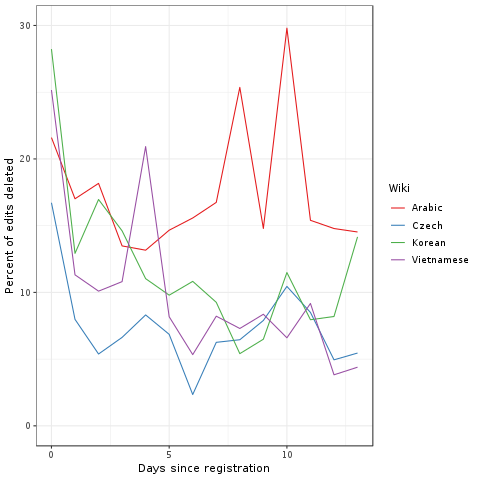

In [76]:
%%R -i newcomer_reverts

ggplot(newcomer_reverts, aes(x = days_since_registration, y = 100 * prop_reverted, fill = wiki_db, color = wiki_db)) +
theme_bw() +
scale_colour_brewer(name = "Wiki", breaks = c("arwiki", "cswiki", "kowiki", "viwiki"),
                    labels = c("Arabic", "Czech", "Korean", "Vietnamese"), palette = "Set1") +
scale_x_continuous("Days since registration") +
scale_y_continuous("Percent of edits deleted", limits = c(0, 30)) +
geom_line()

It's interesting to see the different trends here. In Czech and Korean, it looks like there's a bit of a learning curve here, users are more likely reverted if they edit on their first day, while those who stick around and edit later are more likely to do productive work. In Arabic, that's not true, and it's interesting to see that the revert proportions are so high up until day 14. We also know that IP edits get reverted at a high rate in Arabic, I'm starting to suspect that Arabic WP simply reverts more often than others.

Vietnamese also shows a bit of variation in the curve. There's a bump on day 4, I wonder if that's bot/spam accounts waiting for autoconfirmation. After that, the line is fairly consistent, and much lower than on the earlier days.

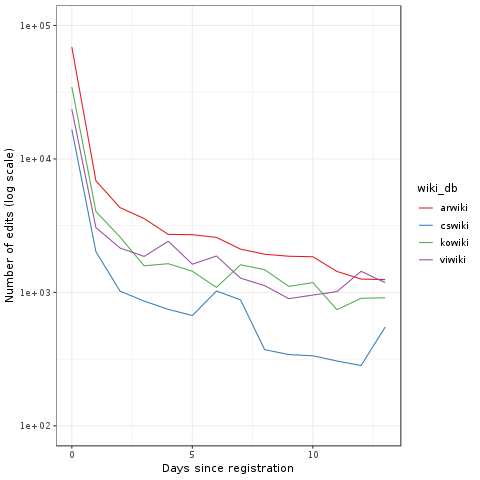

In [77]:
%%R -i newcomer_reverts

ggplot(newcomer_reverts, aes(x = days_since_registration, y = num_edits, fill = wiki_db, color = wiki_db)) +
theme_bw() +
scale_colour_brewer(palette = "Set1") +
scale_x_continuous("Days since registration") +
scale_y_log10("Number of edits (log scale)", limits = c(100, 100000)) +
geom_line()

This is roughly as expected, there's an order of magnitude more edits on the first day than any other day.

Anyways, let's calculate the overall proportions.

In [45]:
newcomer_reverts.head()

,wiki_db,days_since_registration,num_edits,num_reverted,prop_reverted
0,arwiki,0,69750,15453,0.221548
1,arwiki,1,6835,1154,0.168837
2,arwiki,2,4423,814,0.184038
3,arwiki,3,3652,489,0.133899
4,arwiki,4,2853,353,0.123729


In [68]:
edit_reverts_agg = (newcomer_reverts.groupby('wiki_db')
                    .agg({'num_edits' : sum, 'num_reverted': sum})
                    .reset_index()
                    .replace(['arwiki', 'cswiki', 'kowiki', 'viwiki'],
                         ['Arabic', 'Czech', 'Korean', 'Vietnamese']))
edit_reverts_agg['prop_reverted'] = 100 * edit_reverts_agg['num_reverted'] / edit_reverts_agg['num_edits']

In [69]:
print(
    tabulate.tabulate(
        edit_reverts_agg[['wiki_db', 'num_edits', 'num_reverted', 'prop_reverted']].rename(
            columns = {
            'wiki_db' : 'Language',
            'num_reverted' : 'N reverts',
            'num_edits' : 'N edits',
            'prop_reverted' : 'Revert %'}),
        tablefmt = 'github',
        headers = 'keys', showindex = False, numalign = 'right',
        floatfmt = ['', '.0f', '.0f', '.1f']))

| Language   |   N edits |   N reverts |   Revert % |
|------------|-----------|-------------|------------|
| Arabic     |    105494 |       21369 |       20.3 |
| Czech      |     26076 |        3417 |       13.1 |
| Korean     |     56888 |       12359 |       21.7 |
| Vietnamese |     43347 |        7672 |       17.7 |
